# プロダクト開発試験（世利 彰規）

## Abstract

　本プロダクト開発課題では、ライブドアニュースコーパスを用いた日本語文章分類モデルの構築を行いました。9つのカテゴリへの多クラス分類タスクに対し、**4つの中間層**からなる2つの深層学習モデルを構築し、その性能を比較検証しました。両モデルの実装にはPyTorchを用い、テキストの前処理にはJanomeによる形態素解析を適用しました。

　まず、ベースラインとして、局所的な特徴抽出に優れたCNN（畳み込みニューラルネットワーク）と、時系列情報を捉えるGRUを組み合わせたモデルを実装しました。

　次に、改善モデルとして、Transformerの設計思想に基づき、CNNを自己注意機構（Self-Attention）に置き換え、文全体の構造的・文脈的関係性を捉えるモデルを構築しました。

　実験の結果、ベースラインモデルは正解率84.9%を達成しました。一方、残差接続や層正規化を取り入れた改善モデルは、正解率を90.3%まで向上させ、約5.4ポイントの性能向上を確認しました。特に、ベースラインが苦手としていた広範なテーマのカテゴリ（例: livedoor-homme, peachy）において、F1スコアの顕著な改善を確認しました（それぞれ0.62→0.79, 0.69→0.83）。

　以上の結果から、局所的な特徴だけでなく文全体の文脈情報を捉える自己注意機構が、本タスクにおいてCNNよりも優れた特徴抽出器として機能し、分類精度向上に有効であるという結論が得られました。

## 1. テーマ設定

プロダクト開発試験として、課題番号**004**の**文章をカテゴリー分類するモデルの作成**に取り組みました。

データセットとして**ライブドアニュースコーパス**を使用し、単語分散表現・GRUとCNN、Attentionを組み合わせてより良いモデルを作成しました。

## 2. 環境構築

### ライブラリのインストール
必要なライブラリをインストールし、実行環境のバージョンを統一します。

In [1]:
import sys

# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # ライブラリのインストール
    %pip install --no-warn-conflicts torch==2.1.1 torchvision==0.16.1 nltk==3.8.1 janome==0.5.0 numpy
else:
    print("Not Google Colab")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196

### ドライブのマウント

In [2]:
# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # マウントを行う
    from google.colab import drive

    drive.mount("/content/drive")
else:
    print("Not Google Colab")

Mounted at /content/drive


### ライブラリのインポート

In [22]:
import copy
import io
import os
import math
import re
import tarfile
import time
import urllib.request
from typing import Optional

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle
from tqdm.auto import tqdm

from janome.tokenizer import Tokenizer
from nltk import tokenize
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 3. データ収集

### データセットの準備
コーディング試験Chapter11-2で使用したLivedoorニュースコーパスをダウンロードして使用します。
インターネット上に公開されているデータセットを以下のコードでダウンロードします。

In [5]:
PRJ_ROOT = "/content/drive/MyDrive/product_assignment/"
TARGZ_PATH = PRJ_ROOT + "ldcc-20140209.tar.gz"

with urllib.request.urlopen("https://www.rondhuit.com/download/ldcc-20140209.tar.gz") as res:
    with open(TARGZ_PATH, "wb") as f:
        f.write(res.read())

ダウンロードしたファイルは圧縮されているので、作業フォルダに展開します。

In [6]:
tar = tarfile.open(TARGZ_PATH)
tar.extractall(PRJ_ROOT)
tar.close()

### データセットの作成
カテゴリをラベル、ファイル内の文章をデータとしてそれらが対になったデータをCSV形式にして保存します。

In [9]:
from tqdm.auto import tqdm # 進捗バーを表示

# 展開したテキスト群が置かれている親ディレクトリ
DATA_DIR = PRJ_ROOT + 'text/'

# カテゴリ名（サブディレクトリ）のリストを取得
# 不要なファイル（例：LICENSE.txt）は除外
categories = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print("対象カテゴリ：", categories)

# 最終的にDataFrameにするための、行データ（辞書）を格納するためのリスト
all_data = []

# tqdmを使って進捗を表示しながらカテゴリごとにループ
for category in tqdm(categories, desc="カテゴリ処理中"):
    category_path = os.path.join(DATA_DIR, category)

    files = os.listdir(category_path)
    for file_name in files:
        # category内のREADME.mdはスキップ
        if file_name.endswith(".txt"):
            file_path = os.path.join(category_path, file_name)

            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    # 最初の2行はURLとタイムスタンプなので読み飛ばし、3行目以降を本文として取得
                    lines = f.readlines()
                    text_body = "".join(lines[2:]).strip()

                    # ラベル（カテゴリ名）とテキスト本文を辞書としてリストに追加
                    all_data.append( {'label': category, 'text': text_body} )
            except Exception as e:
                print(f"Error readin {file_path}: {e}")

# ループ完了後、リストから一気にDataFrameを作成
df = pd.DataFrame(all_data)

# 作成したDataFrameをCSVとして保存（インデックスは不要なのでindexにはFalseを設定）
df.to_csv(PRJ_ROOT + "livedoor_news_corpus.csv", index=False, encoding="utf-8-sig")

print("\nCSVファイルの作成が完了しました。")
print("データ件数：", len(df))
print("Head：\n", df.head())

対象カテゴリ： ['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


カテゴリ処理中:   0%|          | 0/9 [00:00<?, ?it/s]


CSVファイルの作成が完了しました。
データ件数： 7376
Head：
             label                                               text
0  dokujo-tsushin  友人代表のスピーチ、独女はどうこなしている？\n　もうすぐジューン・ブライドと呼ばれる６月。...
1  dokujo-tsushin  ネットで断ち切れない元カレとの縁\n　携帯電話が普及する以前、恋人への連絡ツールは一般電話が...
2  dokujo-tsushin  相次ぐ芸能人の“すっぴん”披露　その時、独女の心境は？\n　「男性はやっぱり、女性の“すっぴ...
3  dokujo-tsushin  ムダな抵抗！？ 加齢の現実\n　ヒップの加齢による変化は「たわむ→下がる→内に流れる」、バス...
4  dokujo-tsushin  税金を払うのは私たちなんですけど！\n　6月から支給される子ども手当だが、当初は子ども一人当...


### 言語データの前処理

日本語を形態素解析して単語表層形に分かち書きします。

そのうえで単語をIDに変換します。`"CUDA out of memory"` の回避のために文章が512文字を超えた場合には切り詰めを行いました。

文章において重要な情報は後ろの方にあると仮定し、後ろの方から512文字分を切り出すという戦略を取りました。

#### 日本語の分かち書きメソッド

In [10]:
wakati = Tokenizer()

""" 日本語のトークン化 """
def tokenize_ja(sentences_list):
    wakati_list = []
    print("トークン処理を開始します。")
    for sentence in tqdm(sentences_list):
        # tokenizeから返される表層形を分かち書きリストに登録
        wakati_list.append([item.surface for item in wakati.tokenize(sentence)])
    return wakati_list

#### 単語からIDへの辞書を生成

In [11]:
""" 単語からIDへの辞書を作成 """
def create_word_id_dict(sentences):
    word_to_id = {}  # 単語からIDへの変換辞書
    id_to_word = {}  # IDから単語への逆引き辞書
    # 0はパディング／未知語用に予約
    word_to_id['<PAD>/<UNK>'] = 0
    id_to_word[0] = '<PAD>/<UNK>'

    # すべての文章をループ
    for sentence in sentences:
        # 文章内の各単語をループ
        for word in sentence:
            # もし単語がまだ辞書に登録されていなければ、新しいIDを割り振る、
            if word not in word_to_id:
                # 新しいIDとして、現在の辞書のサイズ（登録済みの単語数）を使用する
                tmp_id = len(word_to_id)
                word_to_id[word] = tmp_id
                id_to_word[tmp_id] = word

    # (単語をキー、IDをバリューとする辞書, IDをキー、単語をバリューとする辞書)のタプルを返す
    return word_to_id, id_to_word

#### 文章をID列に変換

In [16]:
""" 単語で構成された文章のリストを対応するIDのリストに変換 """
def convert_sentences_to_ids(sentences, word_to_id):
    sentence_id_list = []
    for sentence in sentences:
        # dict.get(key, default)メソッドによって、未知語でもエラーにならずにデフォルトである<UNK>のIDを返す
        sentence_ids = [word_to_id.get(word, 0) for word in sentence]
        sentence_id_list.append( sentence_ids )

    # IDに変換された文章のリストを返す
    return sentence_id_list

#### 文章のパディング処理

In [13]:
""" IDに変換され文章のリスト"に対して、paddingと打ち切り処理を行う """
def padding_and_truncate_sentence(sentences, max_len=512):
    # 処理が行われた後の文章IDを格納するリスト
    processed_sentences = []

    for sentence in sentences:
        # １．打ち切り
        # 文章の長さが max_lenを超える場合、末尾から max_len分だけを取得します。
        # 文章の末尾に重重要な情報含まれる場合が多いため、前から切り捨てます
        # 改善モデルにおけるMultiheadAttention層が内部で行う計算で、
        # 巨大な行列を作成しようとしてGPUのメモリが足りなくなる問題への対応として実施しました。
        sentence = sentence[-max_len:]

        # ２．padding
        # 文章の長さがmax_lenに満たない場合、差分を計算
        padding_size = max_len - len(sentence)

        # 足りない分だけ <PAD>のIDのリストを作成し、文章の前方に連結
        padding = [0] * padding_size
        processed_sentences.append(padding + sentence)

    return processed_sentences

#### 前処理の実行

In [19]:
# 生のCSVの読み込み
df = pd.read_csv(PRJ_ROOT + "livedoor_news_corpus.csv")

# 文章カテゴリ（ラベル）をID化
label_to_id = {label: i for i, label in enumerate(df['label'].unique())}
id_to_label = {i: label for i, label in enumerate(df['label'].unique())}
df['label_id'] = df['label'].map(label_to_id)

# テキストの分かち書き
ja_sentences = tokenize_ja(df["text"].tolist())

# 単語辞書の作成
word_to_id, id_to_word = create_word_id_dict(ja_sentences)

# 文章をID列に変換
sentence_ids = convert_sentences_to_ids(ja_sentences, word_to_id)

# padding処理
padded_ids = padding_and_truncate_sentence(sentence_ids)

# データをまとめた辞書を作成
processed_data = {
    'padded_ids': padded_ids,
    'labels': df['label_id'].tolist(),
    'word_to_id': word_to_id,
    'id_to_word': id_to_word,
    'label_to_id': label_to_id,
    'id_to_label': id_to_label,
}

# 学習用データはpickle形式にして保存する
with open(PRJ_ROOT + 'processed_data_maxlen512.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print(f"保存ファイル: processed_data_maxlen512.pkl")
print(f"語彙数: {len(word_to_id)}")

トークン処理を開始します。


  0%|          | 0/7376 [00:00<?, ?it/s]

保存ファイル: processed_data_maxlen512.pkl
語彙数: 75130


## 4. 前処理データの読み込みとデータセットの分割

　今回はニュースカテゴリの分類という分類問題を扱います。分類問題に対しては、各カテゴリのデータ比率を保ったまま分割する層化サンプリング（Stratified Sampling） を行うのが最適な方法です。

　もし単純なランダムサンプリングの場合、特定のカテゴリのデータがテストデータにほとんど含まれない、といった事故が生じる可能性があります。

　層化サンプリングではデータが少ないカテゴリも訓練・検証・テストの各データセットに**均等**に分配されます。そのため、そのような事故を回避でき、信頼性の高いモデル評価ができるようになります。

### 前処理データの読み込み

In [20]:
# pklファイルから前処理済みデータを読み込む
PKL_FILE_PATH = PRJ_ROOT + 'processed_data_maxlen512.pkl'
with open(PKL_FILE_PATH, 'rb') as f: # 'rb'：バイナリ読み込みモード
    data = pickle.load(f)

# dataは辞書型オブジェクトとして保存
padded_ids = data['padded_ids']
labels = data['labels']

### データセットの分割

In [23]:
# データを訓練・検証・テスト用に分割
# ※この時点ではまだPythonのリスト型として扱う

# 1. 全体を「訓練＋検証用」（90%）と「テスト用」（10%）に分割
# test_size=0.1: 全体の10％をテストデータとする
# random_state=42: 乱数を固定し、何度実行しても同じ分割結果とする（再現性の確保）
# stratify=labels: 元のデータのラベル比率を保ったまま分割する
train_val_ids, test_ids, train_val_labels, test_labels = train_test_split(
    padded_ids, labels, test_size=0.1, random_state=42, stratify=labels
)

# 2. 次に「訓練＋検証用」のデータを「訓訓用（80%）」と「検証用（10％）」に分割
# train_valデータは全体の90%なので、そのうちの1/9を検証用にすると、全体から見て10%分相当となる
# 0.9 * 1/9 = 0.1
train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_val_ids, train_val_labels, test_size=(1/9), random_state=42, stratify=train_val_labels
)

# PyTorchのDatasetクラスの定義
# Datasetクラス：データとそのラベルと保持し、インデックスを指定して１つずつ取り出すための器
class LivedoorTensorDataset(Dataset):
    def __init__(self, ids, labels):
        # コンストではｈクタ、IDのリストとラベルのリストをインスタンス変数として保持
        self.ids = ids
        self.labels = labels

    def __len__(self):
        # データセット全体のサンプル数を取得
        return len(self.labels)

    def __getitem__(self, index):
        # 指定されたindexのデータを取得。DataLoaderから内部的に呼び出される
        # ここでPythonのリスト型からPyTorchが扱えるTensor型へと変換している
        # dtype=torch.long：整数ID（単語IDやラベルIDを扱う際の標準的なデータ型）
        input_ids = torch.tensor(self.ids[index], dtype=torch.long)
        label_id  = torch.tensor(self.labels[index], dtype=torch.long)
        return input_ids, label_id

# 各データ分割に対応するDatasetインスタンスの作成
# 上記で定義したDatasetクラスを使い、訓練・検証・テストそれぞれのデータセットオブジェクトを作成
train_dataset = LivedoorTensorDataset(train_ids, train_labels)
val_dataset   = LivedoorTensorDataset(val_ids,   val_labels)
test_dataset  = LivedoorTensorDataset(test_ids,  test_labels)

# DataLoaderの作成
# DataLoaderはDatasetをラップし、ミニバッチ処理、データのシャッフル、並列読み込みなどを効率的に行う
BATCH_SIZE = 16 # 一度にモデルを投入するデータ数（バッチサイズ）

# 訓練用DataLoader：データをシャッフルすることで、学習の偏りを防ぎ、モデルの汎用性を向上させる
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# 検証用とテスト用DataLoader：評価時はデータの順序を維持するため、シャッフルは不要
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# モデルのハイパーパラメータ
# データから自動的に設定
vocab_size = len(data['word_to_id']) # 語彙数。単語とIDの対応辞書のサイズから取得
num_classes = len(set(labels)) # 分類クラス数。ラベルの種類数をset()で重複を除いてカウント

# 人間が設定
embedding_dim = 256 # 単語をベクトル表現に変換した際のベクトルの次元数
hidden_dim = 256 # CNNやGRUの中間層（隠れ層）の次元数。モデルの表現力に影響

# 設定したパラメータを画面に出力して確認
print(f"語彙数 (vocab_size): {vocab_size}")
print(f"分類クラス数 (num_classes): {num_classes}")
print(f"単語ベクトルの次元数 (embedding_dim): {embedding_dim}")
print(f"隠れ層の次元数 (hidden_dim): {hidden_dim}")

語彙数 (vocab_size): 75130
分類クラス数 (num_classes): 9
単語ベクトルの次元数 (embedding_dim): 256
隠れ層の次元数 (hidden_dim): 256


## 5. アルゴリズム選択（ベースラインモデル）

### ベースラインモデル設計

　最初にCNNとGRUを1つのディープラーニングモデルの中に層（レイヤー）として組み込み、それぞれの長所を活かす**ハイブリッド**な構造を採用しました。

　今回はLSTMではなく**GRU**を採用しました。GRUはLSTMと比べてゲートの数が少なく構造がシンプルなため、**計算コストが低く学習が速い**傾向にあります。それでいて、多くのタスクで**LSTMと同等**の性能を発揮することが知られています。ここから、今回の課題では、**計算効率**と**実装の容易さ**を考慮し、RNN系手法としてGRUを採用しました。

　CNNは入力された単語ベクトルの並びに対して、**局所的な特徴（n-gramのような短い単語の組み合わせ）**を抽出する役割を果たします。

例えば、「とても面白い」や「つまらない」といったキーフレーズを効率的に見つけ出す役割を担います。

　CNNとGRUの組み合わせを選んだ理由としてこれらの手法の以下の特徴に着目しました：

* CNNの長所: 文中の重要なキーワードやフレーズ（局所的な特徴）を効率的に捉えることができる

* GRUの長所: RNN系列の手法として、単語の系列（シーケンス）の文脈や順序関係を効果的に捉えることができる

この2つを組み合わせることで、**「文章中の重要な部分（CNNが担当）が、どのような文脈で登場したか（GRUが担当）」**を同時に学習できるモデルを作ることができると考えました。

構築したニューラルネットワークは以下のような**4つの中間層**からなる構成となっています：

1. **Embedding層**: 単語をベクトルに変換する層
2. **CNN層** (1次元CNN): 特徴を抽出する層
3. **GRU層**: 系列情報を処理する再帰的な層
4. **全結合層**: 最終的な分類を行う層

### ベースラインモデル作成

In [28]:
""" ベースラインモデル """
class CNN_GRU_Model(nn.Module):
    """
    CNNで系列データから局所的な特徴を抽出します。
    GRUでその特徴の時間的な依存関係を学習します。
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        """
        コンストラクタ

        Args:
            vocab_size (int): 語彙数。入力される単語の種類の数。
            embedding_dim (int): 単語埋め込みベクトルの次元数。
            hidden_dim (int): CNNの出力チャネル数。GRUの隠れ状態の次元数。
            num_classes (int): 出力クラス数。分類したいカテゴリの数。
        """
        super(CNN_GRU_Model, self).__init__()

        # 1. Embedding層
        # 単語IDの系列を単語埋め込みに変換
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # 2. 1次元CNN層（Convolutional Neural Network）
        # 埋め込みベクトルの系列から、n-gramのような局所的な特徴を抽出
        # in_channels: 入力チャネル数（埋め込み次元数）
        # out_channels: 出力チャネル数（抽出される特徴マップの数 = hidden_dim）
        # kernel_size=3: ３つの連続する単語ベクトルを一度に見る（3-gramに相当）
        # padding=1: 畳み込み後も系列長を変化させないためにpaddingを追加
        self.cnn = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU() # 活性化関数

        # 3. GRU（Gated Recurrent Unit）
        # CNNが抽出した特徴系列を入力とし、時間的な依存関係を学習
        # input_size: 各タイムステップにおける入力特徴の次元数（＝CNNの出力チャネル数）
        # hidden_size: GRUの隠れ状態ベクトルの次元数
        # batch_size=True: 入力テンソルの形状を（batch_size, seq_len, input_size）として扱う
        self.gru = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, batch_size=True)

        # 4. 全結合層（Fully Connected Layer）
        # GRUから得られた最終的な文脈ベクトルを、指定されたクラス数にマッピングし、分類スコアを出力
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        順伝播

        Args:
            x (torch.Tensor): 入力データ。単語IDの系列
                            　形状：（batch_size, seq_len）
        Returns:
            torch.Tensor: 各クラスに対する分類スコア
                        　形状：（batch_size, num_clases）
        """
        # 1. Embedding
        # x の形状：（batch_size, seq_len）
        x = self.embedding(x)   # -> (batch_size, seq_len, embedding_len)

        # 2. CNN
        # Conv1dは 入力として(batch, channels, seq_len) の形状を受け付けるため、埋め込みベクトルの次元を入れ替える
        # (batch_size, seq_len, embedding_dim) -> (batch_size, embedding_dim, seq_len)
        #       0         1            2                0            2           1
        x = x.permute(0, 2, 1)

        # 畳み込み層とのの活性化関数を適用
        x = self.cnn(x)         # -> (batch_size, hidden_dim, seq_len)
        x = self.relu(x)

        # 3. GRU
        # GRUの入力（batch_first=True）は（batch, seq, feature）の形状を受け付けるため、再度次元を入れ替える
        # (batch_size, hidden_size, seq_len) -> (batch_size, seq_len, hidden_dim)
        #       0         1            2             0          2          1
        x = x.permute(0, 2, 1)

        # GRUは全てのタイムステップの出力（output）と最期のタイムステップの隠れ状態（h_n）を返す
        # ここでは文脈全体を返す最後の隠れ状態のみ使用
        _, h_n = self.gru(x) # h_nの形状：(num_layers, batch_size, hidden_dim)

        # 4. 全結合層
        # GRuの最後の隠れ状態の次元（num_layer）を解除し、（batch_size, hidden_dim）の形状に整形
        x = h_n.squeeze(0) # -> (batch_size, hidden_dim)

        # 全結合層に入力し、最終的なクラススコアを得ます
        out = self.fc(x) # -> (batch_size, num_classes)

        return out

### ベースラインモデルの学習

In [30]:
# 実行環境（GPU／CPU）の確認と設定
# GPUが利用可能か確認し、利用可能なら "cuda"、そうでなければ "cpu" をdeviceに設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CNN_GRU_Modelのインスタンスを生成し、.to(device)で指定したデバイスにモデルを転送
# モデルのパラメータ（重み）や計算が、指定したデバイスで実施されるようにする
model = CNN_GRU_Model(vocab_size, embedding_dim, hidden_dim, num_classes)
model.to(device)

# 最適化手法と損失関数の定義
# 最適化アルゴリズムとしてAdamを使用
# model.parameters() を渡すことで、モデルが持つすべてのパラメータを最適化の対象として登録
# lrは学習率（learning rate）で、パラメータ更新のステップ幅を決定
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 損失関数としてクロスエントロピー損失を定義
criterion = nn.CrossEntropyLoss()

# モデルの保存設定と学習ループの準備
# 才能の検証損失を保存する変数を初期化することによって、検証データの損失が改善した場合にのみモデルを保存する
# 早期終了（Early Stopping）に近い戦略
best_valid_loss = np.inf
MODEL_SAVE_PATH = PRJ_ROOT + 'baseline_model_best_model.pth' # 最良モデルの保存先ファイルパス

n_epoch = 10 # 学習エポック数
for epoch in range(n_epoch):
    # 各エポックの開始時に、訓練データと検証データの損失と正解数をリセット
    loss_train = 0
    loss_valid = 0
    accuracy_train = 0
    accuracy_valid = 0

    # 訓練モード
    # model.train()を呼び出し、モデルを「訓練モード」に切り替える
    # Dropout層やBatchNorm層などが訓練時の挙動となる
    model.train()
    for x,t in train_loader: # DataLoaderからミニバッチを1件ずつ取り出す
        # データをモデルと同じデバイスに転送
        x = x.to(device)
        t = t.to(device)

        # 前のバッチの勾配が累積しないように勾配をリセットする。
        optimizer.zero_grad()

        # 順伝播
        output = model(x)

        # 損失計算：モデルの出力と正解ラベルとを比較し、損失を計算
        loss = criterion(output, t)
        # 逆伝播：損失に基づいて、各パラメータの勾配を計算
        loss.backward()

        # パラメータ更新：計算された勾配を基に、オプティマイザがモデルのパラメータを更新
        optimizer.step()

        # 予測ラベルを計算。出力が最も大きいクラスを予測結果とするる
        pred = output.argmax(dim=1)

        # このバッチでの損失と正解数を、エポック全体の集計に加算
        # .item()はテンソルからPythonのスカラー値を取り出す
        loss_train += loss.item()
        accuracy_train += torch.sum(pred == t.data)

    # 検証モード
    # model.eval()を呼び出し、モデルを「検証モード」に切り替える
    model.eval()

    # 検証ではパラメータ更新はおこなわず、メモリ消費量を削減し、計算速度は向上する
    with torch.no_grad():
        for x,t in val_loader:
            # データをデバイスに転送
            x = x.to(device)
            t = t.to(device)

            # 順伝播
            output = model(x)

            # 損失計算
            loss = criterion(output, t)

            # 予測ラベルを計算
            pred = output.argmax(dim=1)

            # 損失と正解数を加算
            loss_valid += loss.item()
            # モデルの予測と正解ラベルとが等しいものの個数をカウントして足し合わせる
            accuracy_valid += torch.sum(pred == t.data)

    # エポックごとの結果を計算して表示する
    avg_loss_train = loss_train / len(train_loader)
    avg_loss_valid = loss_valid / len(val_loader)
    avg_acc_train = accuracy_train / len(train_dataset)
    avg_acc_valid = accuracy_valid / len(val_dataset)

    # 結果を整形して表示
    print(
        f"| epoch {epoch+1:2d} | train loss {avg_loss_train:.4f}, acc {avg_acc_train:.4f} "
        f"| valid loss {avg_loss_valid:.4f}, acc {avg_acc_valid:.4f}"
    )

    # 最良モデルの保存
    # 検証データの損失が、これまでの最小値を更新した場合
    if avg_loss_valid < best_valid_loss:
        print(f"Validation loss improved ({best_valid_loss:.4f} --> {avg_loss_valid:.4f}). Saving model...")
        best_valid_loss = avg_loss_valid # 最小損失を更新

        # モデルのパラメータ（重み）のみを保存
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"\nTraining finished. Best model saved to {MODEL_SAVE_PATH}")

Using device: cuda
| epoch  1 | train loss 1.4321, acc 0.5408 | valid loss 1.0008, acc 0.6802
Validation loss improved (inf --> 1.0008). Saving model...
| epoch  2 | train loss 0.8813, acc 0.7173 | valid loss 0.7572, acc 0.7304
Validation loss improved (1.0008 --> 0.7572). Saving model...
| epoch  3 | train loss 0.6993, acc 0.7741 | valid loss 0.8644, acc 0.7114
| epoch  4 | train loss 0.5223, acc 0.8354 | valid loss 0.5371, acc 0.7995
Validation loss improved (0.7572 --> 0.5371). Saving model...
| epoch  5 | train loss 0.4135, acc 0.8737 | valid loss 0.4828, acc 0.8144
Validation loss improved (0.5371 --> 0.4828). Saving model...
| epoch  6 | train loss 0.3355, acc 0.8975 | valid loss 0.4592, acc 0.8184
Validation loss improved (0.4828 --> 0.4592). Saving model...
| epoch  7 | train loss 0.2592, acc 0.9258 | valid loss 0.4070, acc 0.8537
Validation loss improved (0.4592 --> 0.4070). Saving model...
| epoch  8 | train loss 0.2195, acc 0.9375 | valid loss 0.4202, acc 0.8496
| epoch  9 |

### ベースラインモデルの評価

 '/content/drive/MyDrive/product_assignment/baseline_model_best_model.pth' を読み込んでいます...
Accuracy: 0.8496

Classification Report:


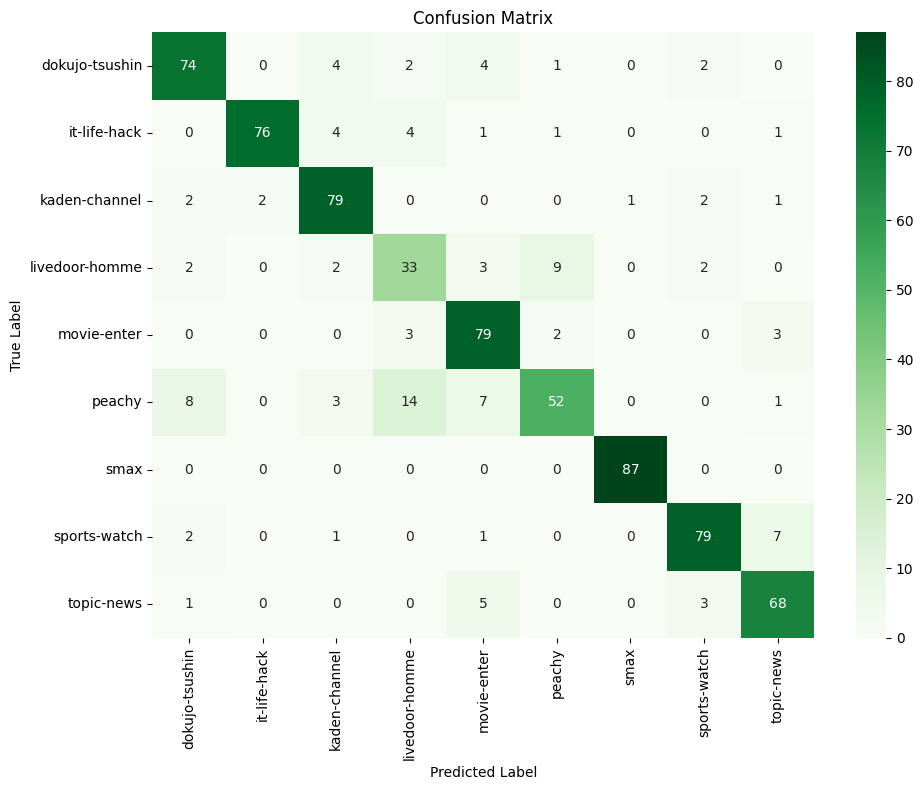

In [43]:
# モデルの評価と結果の可視化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device) # Remove this line as model is instantiated below

print(f" '{PRJ_ROOT + 'baseline_model_best_model.pth'}' を読み込んでいます...")
# Use torch.load to load the model state dictionary
# Load the baseline model
model = CNN_GRU_Model(vocab_size, embedding_dim, hidden_dim, num_classes)
model.to(device)
model.load_state_dict(torch.load(PRJ_ROOT + 'baseline_model_best_model.pth', map_location=device))


# pklファイル内のデータから、IDとカテゴリ名の対応辞書を再取得
# 評価レポートやグラフのラベルとして使用
PKL_FILE_PATH = PRJ_ROOT + 'processed_data_maxlen512.pkl'
# Load the processed data separately to get id_to_label
with open(PKL_FILE_PATH, 'rb') as f: # 'rb'：バイナリ読み込みモード
    processed_data = pickle.load(f)
id_to_label = processed_data['id_to_label']


# 評価レポート用に、カテゴリ名のリストもここから作成
category_names = list(id_to_label.values())

# 全ての予測結果と正解ラベルを格納するための空のリストを準備
all_preds = []
all_labels = []

# モデルを「評価モード」に切り替える
model.eval()

#勾配計算を無効にして計算リソースを削減
with torch.no_grad():
    # テストデータ用のDataLoaderからミニバッチを１件ずつ取り出す
    for x,t in test_loader:
        # データをモデルと同じデバイにに転送
        x = x.to(device)
        t = t.to(device)

        # モデルにデータを入力し、順伝播させる
        output = model(x)

        # 最もスコアの高いクラスのインデックスを予測結果とする
        pred = output.argmax(dim=1)

        # 予測結果と正解ラベルをリストに追加
        #　scikit-learnで計算するために、GPUのTensorからCPU上のリストに変換する
        # .cpu()でCPUに転送し、.tolist()でPythonのリストに変換
        #
        all_preds.extend( pred.cpu().tolist() )
        all_labels.extend( t.cpu().tolist() )
        '''
          当初は.numpy()でNumPy配列に変換しようとしていたが、RuntimeError: Numpy is not availableが発生した。
          これは、NumPyライブラリが見つからない、または利用できない」ことを示している。
          Colab上にプリインストールされていたNumPyが他のライブラリとの兼ね合いなどで不安定になったと思われる。
          ランタイムの再起動／リセットを試したが、改善しなかった。
          対応策として、NumPyを一切経由せず、Tensorを直接Pythonの標準的なリストに変換する .tolist() メソッドを使用した。
          scikit-learnの評価関数はNumPy配列だけでなく、Pythonのリストも受け付けるため、この方法で動作。
        '''

# 正解率（Accuracy）の計算
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 適合率（Precision）、再現率（Recall）、F1スコア（F1-Score）を含むレポートを表示
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=category_names)

# 結果をテキストファイルに保存
with open(DATA_DIR + "CNN_GRU_test_results.txt","w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(report)

# 混合行列（Confusion Matrix）の計算と可視化
cm = confusion_matrix(all_labels, all_preds)

# numpy配列のままだと軸が数字で見づらいため、PandasのDataFrameに変換
# indexとcolumnsにカテゴリ名を設定
cm_df = pd.DataFrame(cm, index=category_names, columns=category_names)

# 可視化
plt.figure(figsize=(10,8)) # グラフのサイズを指定
# seabornのheatmap関数を使って、混合行列をヒートマップとして描画
# annot=True：各セルに数値を表示
# fmt='d': 数値を整数で表示
# cmap='Greens': 色のテーマを指定
sns.heatmap(cm_df, annot=True, cmap='Greens')
plt.title('Confusion Matrix') # グラフのタイトル
plt.ylabel('True Label') # Y軸のラベル
plt.xlabel('Predicted Label') # X軸のラベル

plt.tight_layout() # ラベルがグラフ領域からはみ出ないように自動調整

# 混合行列を画像ファイルとして保存
plt.savefig(PRJ_ROOT + "CNN_GRU_confusion_matrix.png")

plt.show()

#### ベースラインモデルの予測結果の保存

In [34]:
# 予測結果をNumPyファイルとして保存
np.save(PRJ_ROOT + 'cnn_predictions.npy', np.array(all_preds))
print("ベースラインモデルの予測結果を cnn_predictions.npy として保存しました。")

ベースラインモデルの予測結果を cnn_predictions.npy として保存しました。


### ベースラインモデルの考察

#### Classification Report（text/CNN_GRU_test_result.txt）の解釈

* Precision (適合率): モデルが「この記事はこのカテゴリに属する」と予測したもののうち、どれだけが本当に正しかったかを示す割合です。この値が高いカテゴリは、モデルの予測の信頼性が高いことを意味します。

* Recall (再現率): 実際のそのカテゴリのデータ全体のうち、どれだけをモデルが見つけ出せたかを示す割合です。この値が高いカテゴリは、見逃しが少ないことを意味します。

* F1-score (F1スコア): PrecisionとRecallのバランスを取った総合的な指標です。両方の性能をバランス良く評価したい場合に重視します。

* Support: そのカテゴリのテストデータが何件あったかを示します。

👍良好な点 (モデルが得意なカテゴリ)

* smax (スマホ情報): f1-scoreが0.99と、ほぼ完璧に分類できています。専門用語が多く、他のカテゴリと区別しやすいと考えられます。

* it-life-hack (ITニュース): f1-scoreが0.92と、こちらも非常に高い精度です。

* kaden-channel (家電チャンネル): f1-scoreが0.88と、これも得意なようです。

💡全体的に、IT・ガジェット系の専門的な話題は、特徴的な単語が多いため非常に高精度の分類ができていると思われます。


✔課題となる点 (モデルが苦手なカテゴリ)

* livedoor-homme (男性向け情報): f1-scoreが0.62と、最も低い値になっています。
**precisionが0.59と低めです。これは、livedoor-hommeだと予測したもののうち、4割近くが実際は別のカテゴリだった**、ということを意味します。

🤔原因の推測: テーマが幅広いため、他のカテゴリの記事を「これもlivedoor-hommeの記事ではないか」と誤って分類してしまっていると考えられます。

* peachy (女性向け総合情報): f1-scoreが0.69と、2番目に低い値です。
こちらは**recellが0.61と低めです。これは、本来peachyだったもののうち、4割近くを他のカテゴリと間違えている（取りこぼしている）**、ということを意味します。

🤔原因の推測: 「女性向け」というテーマは非常に幅広く、他のカテゴリ（topic-newsやlivedoor-hommeなど）と話題が重複しやすいため、モデルが明確な特徴を見つけにくいのかもしれません。

#### 今後の改善案
さらに精度を上げるための次のステップとして、以下のようなことが考えられます。

Self-Attentionモデルの導入: より高度な特徴量検出方法として、Self-Attentionを用いたモデルを試してみようと思います。CNNよりも文脈を広く捉えることができるため、livedoor-hommeやpeachyのような、単語の組み合わせや文脈のニュアンスが重要なカテゴリの分類精度が向上する可能性があります。

## 6. アルゴリズム選択（改善モデル）

### 自然言語の特徴抽出におけるCNNとAttentionの比較

CNN層が担う「文中の重要な部分（キーフレーズなど）を見つけ出す」という役割は、Attentionメカニズムで代替することが可能であると考えました。

##### CNN層

　CNNは、**「位置的に近い単語の組み合わせ」**に注目します。カーネル（フィルター）と呼ばれる固定サイズの窓を文頭からスライドさせ、局所的なパターン（例：「とても 面白い」「価格が 高い」など）を検出します。

* **強み**: 計算が**高速**で、n-gramのような**局所的**な特徴を捉えるのが得意。

* **弱み**: 窓のサイズが固定されているため、**遠く離れた**単語同士の関係性を捉えるのが苦手。

##### Attentionメカニズム

　Attentionは、**「文脈上、どの単語が他の単語と関連が深いか」**に注目します。文中のある単語を処理する際に、他のすべての単語との関連度（Attentionスコア）を計算し、スコアが高い単語の情報を重点的に利用します。

* **強み**: 距離に関係なく、文全体の文脈から動的に単語の重要度を判断できる。「その」という指示語が文頭のどの名詞を指しているか、といった**長期的な依存関係**を捉えるのが非常に得意。

* **弱み**: 計算量が系列長の2乗に比例して増える（$O(n^2)$ ）ため、非常に長い文章では計算コストが高くなることがある。

### 改善モデル設計

　Attentionは、CNNのように局所的な関係に限定されません。文脈に応じて、隣り合った単語に高いスコアを与えることも、遠く離れた単語に高いスコアを与えることもできます。

　CNNの代わりにAttentionを特徴抽出に利用することで、**文脈情報**をより加味した分類を実現することができ、livedoor-hommeやpeachyのような、**単語の組み合わせ**や**文脈のニュアンス**が重要なカテゴリの分類精度を向上できると考えました。

以下のような**4つの中間層**からなる構成のニューラルネットワークを改善モデルとして考案しました：

1. **Embedding層**: 単語をベクトルに変換する層
2. **Attentionメカニズム** (Self-Attention): 特徴を抽出する層
3. **GRU層**: 系列情報を処理する再帰的な層
4. **全結合層**: 最終的な分類を行う層

### 改善モデル作成

In [37]:
class Attention_GRU_Model(nn.Module):
    """
    Multi-Head Self-Attention機構をGRU前段に組み込んだモデル
    Attention層が入力シーケンス内の単語間の関連性を捉え、
    GRUが時系列に処理することで、より高度な特徴抽出を目指す
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_heads=8):
        """
        コンストラクタ

        Args:
            Vocab_size (int): 語彙数
            embedding_dim (int): 単語埋め込みベクトルの次元数。Attention層の入力次元数でもある
            hidden_dim (int): GRUの隠れ状態の次元数
            num_classes (int): 出力クラス数
            num_heads (int): Multi-Head Attentionのヘッド数
        """
        super(Attention_GRU_Model,self).__init__()

        # 1. Embedding層
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # 2. Attention層（Multi-Head Self-Attention）
        # 入力系列内の各単語が、他のどの単語に注目すべきかを学習します。
        # embeded_dim: 入出力の次元数
        # num_heads: 並列計算のためにAttentionの「ヘッド」をいくつに分割するかを設定
        # batch_first=False: 入力の形式を（seq_len, batch_size, dim）に指定します。
        self.multi_head_attention = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            batch_first=False
        )

        # 学習を安定させるためのレイヤ正規化
        # Attention層に適用
        self.norm1 = nn.LayerNorm(embedding_dim)

        # 3. GRU層
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)

        # 4. 全結合層
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        順伝播

        Args:
            x (torch.Tensro): 入力データ。形状：(batch_size, seq_len)

        Returns:
            torch.Tensor: 各クラスに対する分類スコア。形状：(batch_size, num_classes)
        """
        # 1. Embedding
        x = self.embedding(x) # -> (batch_size, seq_len, embedding_dim)

        # 2. Self-Attention
        # MultiheadAttentionの入力形式 (seq_len, batch_size, dim)に合わせるため、次元を入れ替える
        x_permuted = x.permute(1, 0, 2) # -> (seq_len, batch_size, embedding_dim)

        # Self-Atttentionでは、Query, Key, Valueにすべて同じ入力（x_permuted）を用いる
        # MultiheadAttentionの順伝播
        attn_output, _ = self.multi_head_attention(query=x_permuted, key=x_permuted, value=x_permuted)

        # 残差接続（residual Connection）とレイヤ正規化
        # 入力 x_permuted をAttentionの出たた足し合わせることで、勾配消失を防ぐ
        x = self.norm1(x_permuted + attn_output) # -> (seq_len, batch_size, embedding_dim)

        # 3. GRU
        # GRUの入力形式（batch_size, seq_len, dim）に戻すため、再度次元を入れ替える
        # (seq_len, batch_size, embedding_dim) -> (batch_size, seq_len, embedding_dim)
        #       0         1            2             1          0          2
        x = x.permute(1, 0, 2)

        # GRU層に入力し、最後の隠れ状態 h_n を取得
        _, h_n = self.gru(x) # h_n の形状：（num_layers, batch_size, hidden_dim)

        # 4. 分類
        x = h_n.squeeze(0) # -> (batch_size, hidden_dim)
        # 全結合層で最終的なクラススコアを出力
        out = self.fc(x) # -> (batch_size, num_classes)

        return out

### 改善モデルの学習

In [39]:
# 実行環境（GPU／CPU）の確認と設定
# GPUが利用可能か確認し、利用可能なら "cuda"、そうでなければ "cpu" をdeviceに設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CNN_Attention_Modelのインスタンスを生成し、.to(device)で指定したデバイスにモデルを転送
# モデルのパラメータ（重み）や計算が、指定したデバイスで実施されるようにする
model = Attention_GRU_Model(vocab_size, embedding_dim, hidden_dim, num_classes)
model.to(device)

# 最適化手法と損失関数の定義
# 最適化アルゴリズムとしてAdamを使用
# model.parameters() を渡すことで、モデルが持つすべてのパラメータを最適化の対象として登録
# lrは学習率（learning rate）で、パラメータ更新のステップ幅を決定
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 損失関数としてクロスエントロピー損失を定義
criterion = nn.CrossEntropyLoss()

# モデルの保存設定と学習ループの準備
# 才能の検証損失を保存する変数を初期化することによって、検証データの損失が改善した場合にのみモデルを保存する
# 早期終了（Early Stopping）に近い戦略
best_valid_loss = np.inf
MODEL_SAVE_PATH = PRJ_ROOT + 'improved_model_best_model.pth' # 最良モデルの保存先ファイルパス

n_epoch = 10 # 学習エポック数
for epoch in range(n_epoch):
    # 各エポックの開始時に、訓練データと検証データの損失と正解数をリセット
    loss_train = 0
    loss_valid = 0
    accuracy_train = 0
    accuracy_valid = 0

    # 訓練モード
    # model.train()を呼び出し、モデルを「訓練モード」に切り替える
    # Dropout層やBatchNorm層などが訓練時の挙動となる
    model.train()
    for x,t in train_loader: # DataLoaderからミニバッチを1件ずつ取り出す
        # データをモデルと同じデバイスに転送
        x = x.to(device)
        t = t.to(device)

        # 前のバッチの勾配が累積しないように勾配をリセットする。
        optimizer.zero_grad()

        # 順伝播
        output = model(x)

        # 損失計算：モデルの出力と正解ラベルとを比較し、損失を計算
        loss = criterion(output, t)
        # 逆伝播：損失に基づいて、各パラメータの勾配を計算
        loss.backward()

        # パラメータ更新：計算された勾配を基に、オプティマイザがモデルのパラメータを更新
        optimizer.step()

        # 予測ラベルを計算。出力が最も大きいクラスを予測結果とするる
        pred = output.argmax(dim=1)

        # このバッチでの損失と正解数を、エポック全体の集計に加算
        # .item()はテンソルからPythonのスカラー値を取り出す
        loss_train += loss.item()
        accuracy_train += torch.sum(pred == t.data)

    # 検証モード
    # model.eval()を呼び出し、モデルを「検証モード」に切り替える
    model.eval()

    # 検証ではパラメータ更新はおこなわず、メモリ消費量を削減し、計算速度は向上する
    with torch.no_grad():
        for x,t in val_loader:
            # データをデバイスに転送
            x = x.to(device)
            t = t.to(device)

            # 順伝播
            output = model(x)

            # 損失計算
            loss = criterion(output, t)

            # 予測ラベルを計算
            pred = output.argmax(dim=1)

            # 損失と正解数を加算
            loss_valid += loss.item()
            # モデルの予測と正解ラベルとが等しいものの個数をカウントして足し合わせる
            accuracy_valid += torch.sum(pred == t.data)

    # エポックごとの結果を計算して表示する
    avg_loss_train = loss_train / len(train_loader)
    avg_loss_valid = loss_valid / len(val_loader)
    avg_acc_train = accuracy_train / len(train_dataset)
    avg_acc_valid = accuracy_valid / len(val_dataset)

    # 結果を整形して表示
    print(
        f"| epoch {epoch+1:2d} | train loss {avg_loss_train:.4f}, acc {avg_acc_train:.4f} "
        f"| valid loss {avg_loss_valid:.4f}, acc {avg_acc_valid:.4f}"
    )

    # 最良モデルの保存
    # 検証データの損失が、これまでの最小値を更新した場合
    if avg_loss_valid < best_valid_loss:
        print(f"Validation loss improved ({best_valid_loss:.4f} --> {avg_loss_valid:.4f}). Saving model...")
        best_valid_loss = avg_loss_valid # 最小損失を更新

        # モデルのパラメータ（重み）のみを保存
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"\nTraining finished. Best model saved to {MODEL_SAVE_PATH}")

Using device: cuda
| epoch  1 | train loss 1.4219, acc 0.5478 | valid loss 0.9722, acc 0.6816
Validation loss improved (inf --> 0.9722). Saving model...
| epoch  2 | train loss 0.7113, acc 0.7731 | valid loss 0.5394, acc 0.8157
Validation loss improved (0.9722 --> 0.5394). Saving model...
| epoch  3 | train loss 0.4364, acc 0.8615 | valid loss 0.4307, acc 0.8618
Validation loss improved (0.5394 --> 0.4307). Saving model...
| epoch  4 | train loss 0.3120, acc 0.8969 | valid loss 0.3541, acc 0.8916
Validation loss improved (0.4307 --> 0.3541). Saving model...
| epoch  5 | train loss 0.2282, acc 0.9302 | valid loss 0.3242, acc 0.9106
Validation loss improved (0.3541 --> 0.3242). Saving model...
| epoch  6 | train loss 0.1741, acc 0.9495 | valid loss 0.3180, acc 0.9038
Validation loss improved (0.3242 --> 0.3180). Saving model...
| epoch  7 | train loss 0.1261, acc 0.9632 | valid loss 0.3019, acc 0.9024
Validation loss improved (0.3180 --> 0.3019). Saving model...
| epoch  8 | train loss 0

### 改善モデルの評価

 '/content/drive/MyDrive/product_assignment/improved_model_best_model.pth' を読み込んでいます...
Accuracy: 0.9038

Classification Report:


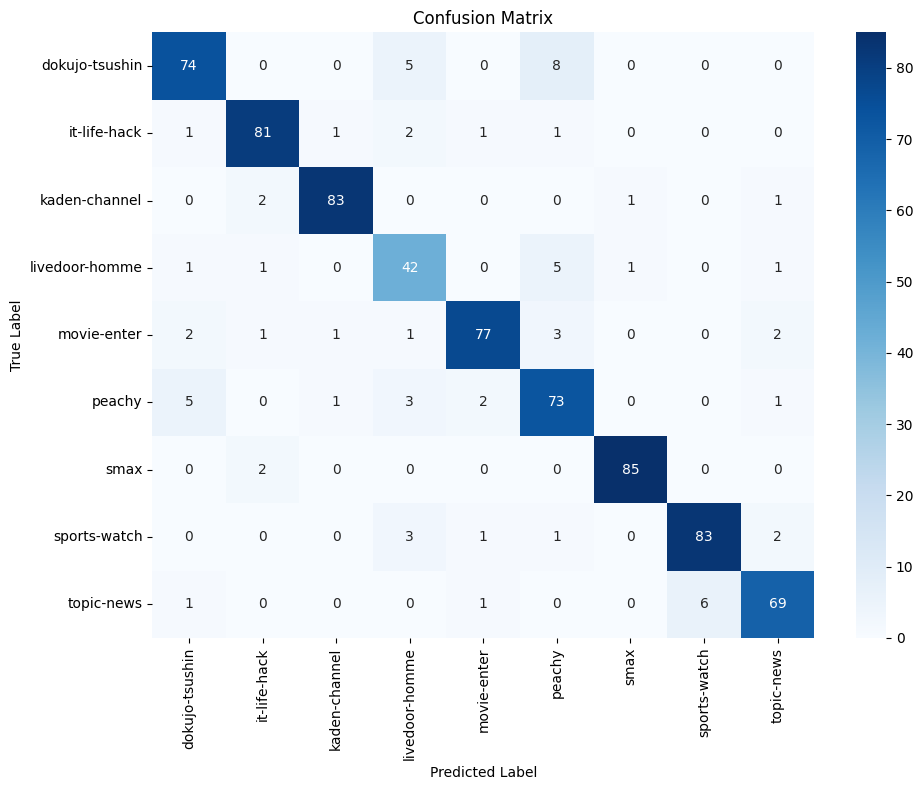

In [41]:
# モデルの評価と結果の可視化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f" '{PRJ_ROOT + 'improved_model_best_model.pth'}' を読み込んでいます...")
# torch.loadを使って学習済みモデルをロード
model.load_state_dict(torch.load(PRJ_ROOT + 'improved_model_best_model.pth', map_location=device))

# pklファイル内のデータから、IDとカテゴリ名の対応辞書を再取得
# 評価レポートやグラフのラベルとして使用
id_to_label = data['id_to_label']

# 評価レポート用に、カテゴリ名のリストもここから作成
category_names = list(id_to_label.values())

# 全ての予測結果と正解ラベルを格納するための空のリストを準備
all_preds = []
all_labels = []

# モデルを「評価モード」に切り替える
model.eval()

#勾配計算を無効にして計算リソースを節約
with torch.no_grad():
    # テストデータ用のDataLoaderからミニバッチを１件ずつ取り出す
    for x,t in test_loader:
        # データをモデルと同じデバイにに転送
        x = x.to(device)
        t = t.to(device)

        # モデルにデータを入力し、順伝播させる
        output = model(x)

        # 最もスコアの高いクラスのインデックスを予測結果とする
        pred = output.argmax(dim=1)

        # 予測結果と正解ラベルをリストに追加
        #　scikit-learnで計算するために、GPUのTensorからCPU上のリストに変換する
        # .cpu()でCPUに転送し、.tolist()でPythonのリストに変換
        #
        all_preds.extend( pred.cpu().tolist() )
        all_labels.extend( t.cpu().tolist() )
        '''
          当初は.numpy()でNumPy配列に変換しようとしていたが、RuntimeError: Numpy is not availableが発生した。
          これは、NumPyライブラリが見つからない、または利用できない」ことを示している。
          プリインストールされていたNumPyが他のライブラリとの兼ね合いなどで不安定になったと思われる。
          ランタイムのリセット等を試したが、改善しなかったので、NumPyを一切経由せず、
          Tensorを直接Pythonの標準的なリストに変換する .tolist() メソッドを使用した。
          scikit-learnの評価関数はNumPy配列だけでなく、Pythonのリストも受け付けるため、この方法で問題なく動作。
        '''

# 正解率（Accuracy）の計算
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 適合率（Precision）、再現率（Recall）、F1スコア（F1-Score）を含むレポートを表示
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=category_names)

# 結果をテキストファイルに保存
with open(DATA_DIR + "Attention_GRU_test_results.txt","w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(report)

# 混合行列（Confusion Matrix）の計算と可視化
cm = confusion_matrix(all_labels, all_preds)

# numpy配列のままだと軸が数字で見づらいため、PandasのDataFrameに変換
# indexとcolumnsにカテゴリ名を設定
cm_df = pd.DataFrame(cm, index=category_names, columns=category_names)

# 可視化
plt.figure(figsize=(10,8)) # グラフのサイズを指定
# seabornのheatmap関数を使って、混合行列をヒートマップとして描画
# annot=True：各セルに数値を表示
# fmt='d': 数値を整数で表示
# cmap='Greens': 色のテーマを指定
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix') # グラフのタイトル
plt.ylabel('True Label') # Y軸のラベル
plt.xlabel('Predicted Label') # X軸のラベル

plt.tight_layout() # ラベルがグラフ領域からはみ出ないように自動調整

# 混合行列を画像ファイルとして保存
plt.savefig(PRJ_ROOT + "Attention_GRU_confusion_matrix.png")

plt.show()

#### 改善モデルの予測結果の保存

In [44]:
# 予測結果をNumPyファイルとして保存
np.save(PRJ_ROOT + 'attention_predictions.npy', np.array(all_preds))
print("改善モデルの予測結果を attention_predictions.npy として保存しました。")

改善モデルの予測結果を attention_predictions.npy として保存しました。


### 改善モデルの考察

#### ベースラインモデルとの比較分析

##### 1. 正解率（Accuracy）が大きく向上
* CNNモデル: 84.9%

* Attentionモデル: 90.3%

　正解率が約5.4%ほど向上しています。

##### 2. 苦手としていたカテゴリが改善
　以前のモデルで誤分類しがちだった2つのカテゴリを見てみます。

【livedoor-homme】

* CNNモデル (F1スコア): 0.62

* Attentionモデル (F1スコア): 0.79

　F1スコアが0.17ポイントも上昇しました。precisionが0.59から0.75と顕著な改善を見せており、誤ってlivedoor-hommeと分類することが少なくなっていると考えられます。


【peachy】

* CNNモデル (F1スコア): 0.69

* Attentionモデル (F1スコア): 0.83

　こちらもF1スコアが0.14ポイント上昇しました。特に、モデルが見逃しがちだったことを示すrecallが 0.61 → 0.86 と大幅に改善しており、これまで別のカテゴリに分類してしまっていた記事を正しく分類できるようになったことが分かります。

この結果から、Self-Attentionが、文全体の文脈や単語間の複雑な関係性を捉えることで、テーマが広範なカテゴリの分類精度を向上させたと推測できます。

## 7. 考察と今後の課題

### 考察

エラー分析として、誤分類してしまった例を調査して原因を考察します。実際にモデルが間違えた記事を人間がいくつか読んでみて、なぜ間違えたのかを分析することで新たな改善のヒントが見つけようと試みました。

#### ベースラインモデル／改善モデルの予測結果サンプルを抽出

In [61]:
# 1. 保存した両モデルの予測結果をロード
cnn_preds = np.load(PRJ_ROOT + 'cnn_predictions.npy').tolist()
attention_preds = np.load(PRJ_ROOT + 'attention_predictions.npy').tolist()

# 2. pklファイルから前処理済みデータと辞書をロード
with open(PRJ_ROOT + 'processed_data_maxlen512.pkl', 'rb') as f:
    data = pickle.load(f)
id_to_label = data['id_to_label']

# 3. テストデータの「原文」と「正解ラベル」を再取得
#    データ分割時と全く同じ random_state を使うことで、同じ分割を再現する
from sklearn.model_selection import train_test_split
raw_df = pd.read_csv(PRJ_ROOT + 'livedoor_news_corpus.csv') # 元の生データCSV

# livedoor_news_corpus.csv からテキストとラベルを取得
X_raw = raw_df['text']
y_raw = raw_df['label'].map({label: i for i, label in enumerate(raw_df['label'].unique())}) # ラベルを数値化

# 分割してテストデータを取得（以前の分割と全く同じ設定）
_, X_test_raw, _, test_labels = train_test_split(
    X_raw, y_raw, test_size=0.1, random_state=42, stratify=y_raw
)

test_texts = X_test_raw.tolist()

# --- ここからが分析コード本体 ---

# テストデータの原文、正解ラベル、両モデルの予測結果をまとめたDataFrameを作成
results_df = pd.DataFrame({
    'text': test_texts,
    'true_label': test_labels,
    'cnn_pred': cnn_preds,
    'attention_pred': attention_preds
})

# IDをカテゴリ名に変換
results_df['true_label_name'] = results_df['true_label'].map(id_to_label)
results_df['cnn_pred_name'] = results_df['cnn_pred'].map(id_to_label)
results_df['attention_pred_name'] = results_df['attention_pred'].map(id_to_label)

# --- 抽出条件 ---
condition1 = results_df['cnn_pred'] != results_df['true_label']
condition2 = results_df['attention_pred'] != results_df['true_label']

cnn_gru_examples = results_df[condition1]
attention_gru_examples = results_df[condition2]


# --- 結果の表示 ---
print("CNN GRU モデルの誤分類例")
for index, row in cnn_gru_examples.head(5).iterrows():
    print(f"正解カテゴリ: {row['true_label_name']}")
    print(f"  - CNNの予測: {row['cnn_pred_name']}")
    print(f"  - Attentionの予測: {row['attention_pred_name']}")
    print("\n【記事本文 (冒頭部分)】")
    print(row['text'][:200] + "...")
    print("="*200)

print("Attention GRU モデルの誤分類例")
for index, row in attention_gru_examples.head(5).iterrows():
    print(f"正解カテゴリ: {row['true_label_name']}")
    print(f"  - CNNの予測: {row['cnn_pred_name']}")
    print(f"  - Attentionの予測: {row['attention_pred_name']}")
    print("\n【記事本文 (冒頭部分)】")
    print(row['text'][:200] + "...")
    print("="*200)

CNN GRU モデルの誤分類例
正解カテゴリ: kaden-channel
  - CNNの予測: sports-watch
  - Attentionの予測: sports-watch

【記事本文 (冒頭部分)】
盗撮現場を配信!?　無料イベント中継のはずが衝撃的瞬間が発覚【話題】
イベントの様子をネット上で配信するということはいまでは珍しくない。今回、そんなイベント中に驚くような光景が配信された。

制汗スプレーのイベントなのだが、実際に利用してもらうというイベントがネット上でも配信されていた。

そこで配信されたのはイベントの中で、参加者がキャンペーンガールのスカートの中を盗撮しているように見えるものが...
正解カテゴリ: livedoor-homme
  - CNNの予測: peachy
  - Attentionの予測: peachy

【記事本文 (冒頭部分)】
世界初！ F1が音楽フェス会場を疾走する！　震災の復興支援のためチャリティー・ラン開催！
世界的DJであるFATBOY SLIM公認のビーチパーティー「BIG BEACH FESTIVAL」が今年も2011年6月4日（土）千葉県幕張海浜公園にて開催される。大好評だった昨年に引き続き、今回で3度目の夏フェスとなる。

「BIG BEACH FESTIVAL」とは、英国ブライトンにおいて25万人ものオ...
正解カテゴリ: sports-watch
  - CNNの予測: topic-news
  - Attentionの予測: topic-news

【記事本文 (冒頭部分)】
日本、フランスとの対戦に「仮想スペインかよ」の声  
　日本サッカー協会は27日、10月12日(日本時間翌13日)にフランス代表と対戦することを発表した。日本代表の海外遠征の一環となる。フランスとの対戦は、2003年6月20日にサンテティエンヌ(フランス)で行なわれたコンフェデレーションズカップ以来のこと。

　2003年当時、ジーコ監督率いる日本は中田英寿、遠藤保仁、中村俊輔らが出場。中村がGK...
正解カテゴリ: sports-watch
  - CNNの予測: topic-news
  - Attentionの予測: topic-news

【記事本文 (冒頭部分)】
横浜・中畑監督を痛烈に批判、「精神面を問

上に挙げた数例を分析して分かることをまとめます：

1. キーワードへの依存：モデルは記事のトピックをキーワードを見て判断しているようです。そのため、あるカテゴリに典型的であるが、他のカテゴリにも登場しうる単語（イベント、発表など）があると、それに強く影響を受けてしまうようです。

2. 曖昧なカテゴリの境界：キーワードとは別にカテゴリの違いが曖昧な場合も誤った分類をする傾向があるようです。例えば、livedoor-hommeとpeachy、sports-watchとtopic-newsのように内容が重複しがちなカテゴリを正しく分類できない場合があります。

3. 文脈理解の限界: Self-Attentionで性能は向上したものの、人間のように「この記事はファッションの話だから、コレクションという単語が出てきても家電ではない」といった常識に基づいた判断はできません。あくまで統計的なパターン認識の範囲内での予測となります。


### 今後の課題

　最後に、モデルをより改善していくための方法を検討しました。

結論として、大規模言語モデル（BERT）の活用が考えられます。BERTを使うことで期待できる効果を以下に挙げます。

* 今回使用したGRUのようなRNN系モデルは文章を左から右へと一方向に順番に読み込みます。一方、BERTは文章の全単語を一度に、同時に、そして**双方向**から見渡します。これにより、単なるキーワードの有無だけでなく、その単語がどのような文脈で使われているかを理解することができ、1.の「キーワードへの依存」から脱却できると考えられます。

*  BERTはWikipediaやWebサイトなど、膨大な量のテキストデータを**事前に**学習しているため、男性的な言い回し、女性的な言い回し、それぞれのメディアで扱われやすいトピックの微妙な違いといった、非常に繊細な言語ニュアンスも識別できるとされています。そのため微細なニュアンスから、2. の「曖昧なカテゴリ」の高精度な分類も可能になると考えられます。

*  BERTは事前学習によって、単語の意味だけではなく、ある程度の「**常識**」も獲得しています。常識を理解していることから、3.の「文脈理解の限界」を越えて、ある程度常識に基づいた判断が期待できます。


以上の点から、BERTを活用することがより高い分類精度を達成するために有効であると考えられます。現在の自然言語処理の最先端であり、最も成果が出やすいアプローチであるBERTを採用した分類モデルの構築が今後の課題となります。

### 参考

1. https://sanshonoki.hatenablog.com/entry/2024/12/16/222245
2. https://note.com/mim_2020/n/nb151cc294c7c
3. https://qiita.com/shinochin/items/8b6b7e76bf426ab86444
4. https://qiita.com/maskot1977/items/cf442ea2968263c83998
5. https://www.kikagaku.co.jp/kikagaku-blog/pytorch1/